In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from collections import Counter

In [2]:
dfabundance = pd.read_csv('Data/abundance', header=0, index_col=0, sep='\t')
dfabundance.head()

,insitu1,insitu2,insitu3,insitu4,insitu5,insitu6,onboard1,onboard2,onboard3,onboard4,onboard5,onboard6,onboard7,taxonomy,taxonomy2
AB239761.1.1412,0.000519,0.000109,0.000039,0.000078,0.000148,0.000039,0.000183,0.000523,0.000105,0.000169,0.000203,NaN,0.000178,Bacteria;Proteobacteria;Gammaproteobacteria;Th...,uncultured bacterium
AB239762.1.1382,0.000259,0.000036,0.000157,0.000105,0.000037,0.000079,NaN,NaN,0.000052,0.000042,0.000017,NaN,0.000118,Bacteria;Bacteroidetes;Flavobacteriia;Flavobac...,uncultured bacterium
AB278150.1.1475,0.000130,NaN,0.000118,0.000052,0.000037,NaN,0.000061,NaN,NaN,NaN,0.000085,0.000062,0.000059,Bacteria;Proteobacteria;Epsilonproteobacteria;...,uncultured bacterium
AB440165.1.1431,0.003759,0.006115,0.007495,0.004965,0.003813,0.006490,0.001710,0.001764,0.001281,0.001735,0.001356,0.000997,0.001598,Bacteria;Proteobacteria;Epsilonproteobacteria;...,uncultured bacterium
AB440166.1.1430,0.000130,0.000072,0.000157,0.000052,0.000074,0.000079,0.000122,0.000196,NaN,0.000169,NaN,NaN,0.000059,Bacteria;Proteobacteria;Epsilonproteobacteria;...,uncultured bacterium


In [3]:
taxa = dfabundance["taxonomy"].str.split(";", expand=True).iloc[:,0:7]
taxa.columns = ["domain","phylum","class","order","family","genus","species"]
taxa.replace('', np.nan, inplace=True)
taxa.fillna("None", inplace=True)

dfabundance_tax = pd.concat([dfabundance, taxa], axis=1, sort=False)

dforder=dfabundance_tax.groupby('order').sum()

In [4]:
def Minimum_all(df, minimum, colname):
    # > minimum in all samples
    
    tmp = df.where(df >= minimum).dropna(how='any')
    df_tmp = pd.concat([tmp, df], axis=1, join_axes=[tmp.index])
    df_high = df_tmp.iloc[:,13:26]

    tmp = df.where(df < minimum).dropna(how='all')
    df_tmp = pd.concat([tmp, df], axis=1, join_axes=[tmp.index])
    df_low = df_tmp.iloc[:,13:26]

    df_high.loc[colname] = df_low.sum()
    return df_high

In [5]:
df_minimumall = Minimum_all(dforder, 0.01, "< 0.01")
df_minimumall

,insitu1,insitu2,insitu3,insitu4,insitu5,insitu6,onboard1,onboard2,onboard3,onboard4,onboard5,onboard6,onboard7
order,,,,,,,,,,,,,
Campylobacterales,0.093466,0.137900,0.192999,0.135018,0.139779,0.181207,0.110575,0.109122,0.095607,0.108986,0.094738,0.102137,0.063869
Methylococcales,0.345994,0.437979,0.359312,0.374794,0.429000,0.417322,0.302723,0.281364,0.336532,0.279108,0.337956,0.323425,0.369184
Thiotrichales,0.531760,0.394485,0.418648,0.462306,0.404235,0.374292,0.560996,0.580829,0.543907,0.578990,0.533840,0.537484,0.520303
< 0.01,0.028779,0.029635,0.029040,0.027882,0.026986,0.027179,0.025705,0.028685,0.023954,0.032916,0.033467,0.036954,0.046644


In [6]:
from scipy import stats

def MannWhitneyU(df):
    for i in range(len(df.index)):
        insitu = list(df.iloc[i,0:6])
        onboard = list(df.iloc[i,6:14])
        res = stats.mannwhitneyu(insitu, onboard, alternative='two-sided')
        result = print(res, df.index[i])   
    return result

MannWhitneyU(df_minimumall)

MannwhitneyuResult(statistic=36.0, pvalue=0.03831876314941356) Campylobacterales
MannwhitneyuResult(statistic=40.0, pvalue=0.008220971320688577) Methylococcales
MannwhitneyuResult(statistic=1.0, pvalue=0.005340992525067206) Thiotrichales
MannwhitneyuResult(statistic=15.0, pvalue=0.43203489200500755) < 0.01


In [7]:
# rearrangement for fig
figureorder = {'Thiotrichales': 0, 'Methylococcales': 1, 'Campylobacterales': 2}
df_minimumall['figureorder'] = df_minimumall.index.map(figureorder)
dfsorted=df_minimumall.sort_values('figureorder')

df = dfsorted.drop(['figureorder'], axis=1).T

df['stabilization method'] = ['in situ','in situ','in situ','in situ','in situ','in situ', 'onboard','onboard','onboard','onboard','onboard','onboard','onboard']

dffig= pd.melt(df, id_vars=['stabilization method'], value_vars=dfsorted.index)
dffig.replace('in situ', '$\it{in}$ $\it{situ}$', inplace=True)

/home/motoki/local/lib/python3.6/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


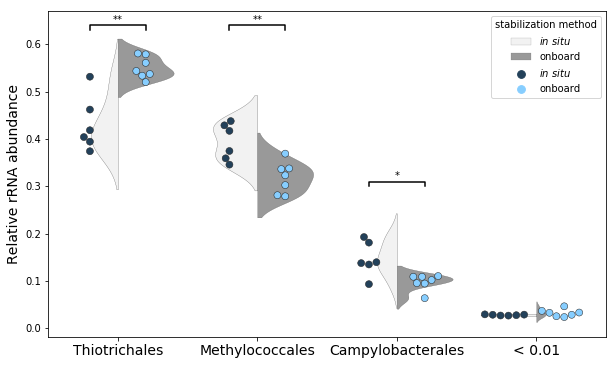

In [8]:
fig = plt.figure(figsize=(10, 6))
fixation_col = ['#23415a', '#87ceff']

sns.violinplot(x='order', y='value', data=dffig, hue='stabilization method', 
               split=True, inner=None, color="0.6", linewidth=0.3, label=False, fontsize=14)

sns.swarmplot(x='order', y='value', data=dffig, hue='stabilization method', 
              palette=fixation_col, split=True, linewidth=0.5, size=7)

# labels
plt.xlabel('')
plt.ylabel('Relative rRNA abundance', fontsize=14)
plt.xticks(rotation=0, fontsize=14)

# tests
y = [0.63, 0.63, 0.30, 0.30]
stats = ['**','**','*']

for i in range(len(stats)):
    x1, x2 = [-0.2+i, 0.2+i]
    plt.plot([x1, x1, x2, x2], [y[i], y[i]+0.01, y[i]+0.01, y[i]], lw=1.5, c='k')
    plt.text((x1+x2)*.5, y[i]+0.012, stats[i], ha='center', va='bottom', color='k')

plt.savefig('Figures/Fig1.pdf', bbox_inches='tight')
plt.show()